# Data Exploration

Loading Data and importing requirements

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/Teeth DataSet.zip" -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Teeth_Dataset/Validation/CoS/b_111_0_6094.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/CoS/b_150_0_2905.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/OT/ot_1241_0_1157.jpg  
  inflating: /content/data/Teeth_Dataset/Validation/CoS/b_95 - Copy_0_6372.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/CaS/a_152_0_7749.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/CaS/a_126_0_9339.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/outputs/a_110_0_9820.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/outputs/a_141_0_7620.jpg  
  inflating: /content/data/Teeth_Dataset/Validation/CoS/b_132_0_2266.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/outputs/a_99_0_9803.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/OT/ot_1223_0_6812.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/OT/ot_1223_0_6082.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/output/

In [91]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 30  # Increased slightly as we don't have early stopping
LEARNING_RATE = 1e-3
L2_REG = 0.001

Check GPU

In [82]:
print("🔍 Checking GPU availability...")
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))
print()

if len(tf.config.list_physical_devices('GPU')) == 0:
    print("⚠️ WARNING: No GPU detected! Training will be VERY slow.")
    print("   Fix: Runtime → Change runtime type → GPU → Save")
    print()
else:
    print("✅ GPU is available! Training will be fast.")
    print()

🔍 Checking GPU availability...
Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ GPU is available! Training will be fast.



Create Output Directories

In [4]:
!mkdir -p /content/drive/MyDrive/teeth_classification/outputs/figures
!mkdir -p /content/drive/MyDrive/teeth_classification/outputs/models
!mkdir -p /content/drive/MyDrive/teeth_classification/outputs/results

Data Paths

In [11]:
BASE_DIR = '/content/data/Teeth_Dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
VALID_DIR = os.path.join(BASE_DIR, 'Validation')
TEST_DIR = os.path.join(BASE_DIR, 'Testing')

# Check folders exist
print(f"Training folder exists: {os.path.exists(TRAIN_DIR)}")
print(f"Validation folder exists: {os.path.exists(VALID_DIR)}")
print(f"Testing folder exists: {os.path.exists(TEST_DIR)}")
print()

print(os.listdir(TRAIN_DIR))
print(os.listdir(VALID_DIR))
print(os.listdir(TEST_DIR))

Training folder exists: True
Validation folder exists: True
Testing folder exists: True

['OLP', 'Gum', 'CaS', 'OT', 'OC', 'CoS', 'MC']
['OLP', 'Gum', 'CaS', 'OT', 'OC', 'CoS', 'MC']
['OLP', 'outputs', 'Gum', 'CaS', 'out', 'output', 'OT', 'output_image.jpg', 'OC', 'CoS', 'MC']


Explore Data

In [12]:
class_names = sorted(os.listdir(TRAIN_DIR))
print(f"Classes found: {class_names}")
print(f"Number of classes: {len(class_names)}")
print()

class_counts = {}
for class_name in class_names:
    class_path = os.path.join(TRAIN_DIR, class_name)
    count = len(os.listdir(class_path))
    class_counts[class_name] = count
    print(f"  {class_name}: {count} images")

print(f"\nTotal training images: {sum(class_counts.values())}")
print()

Classes found: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Number of classes: 7

  CaS: 480 images
  CoS: 450 images
  Gum: 360 images
  MC: 540 images
  OC: 324 images
  OLP: 540 images
  OT: 393 images

Total training images: 3087



Visualize Class Distribution



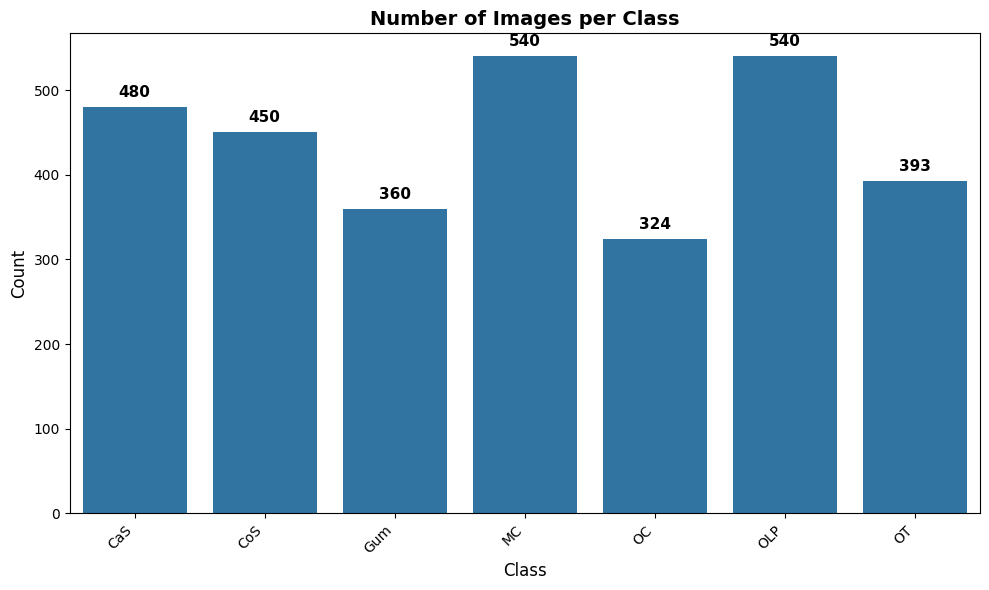

✅ Saved: class_distribution.png



In [14]:
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45, ha='right')
plt.title("Number of Images per Class", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add counts on top of bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/teeth_classification/outputs/figures/class_distribution.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: class_distribution.png\n")

Sample Images from each Class

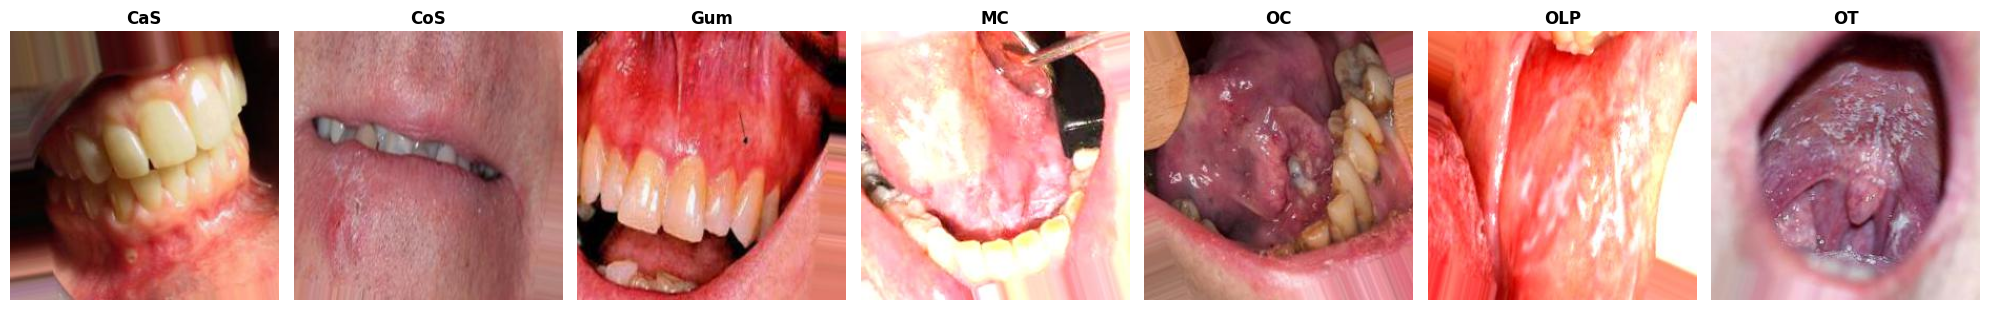

✅ Saved: sample_images_per_class.png



In [15]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, 7, figsize=(20, 3))

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(TRAIN_DIR, class_name)
    img_name = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, img_name)

    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name, fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/teeth_classification/outputs/figures/sample_images_per_class.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: sample_images_per_class.png\n")


# Preprocessing

In [84]:
print("\n⚖️ Computing class weights...")
y_train = []
for _, labels in train_ds: # Iterate through all batches
    y_train.extend(labels.numpy())
y_train = np.array(y_train)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_vals))
print(f"Class Weights: {class_weights}")
# --- Data Pipeline Optimization ---
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False):
    # Rescaling done in model, so just prefetch/cache here
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)



⚖️ Computing class weights...
Class Weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


Define augmentation and normalization

In [85]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

normalization_layer = tf.keras.layers.Rescaling(1./255)

Load dataset

In [86]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

print("Loading datasets...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='int'
)
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Classes found: {class_names}")
val_ds = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='int'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='int'
)

print("✅ Datasets loaded\n")

Loading datasets...
Found 3087 files belonging to 7 classes.
Classes found: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
✅ Datasets loaded



Visualize Augmentation

Generating augmentation examples...


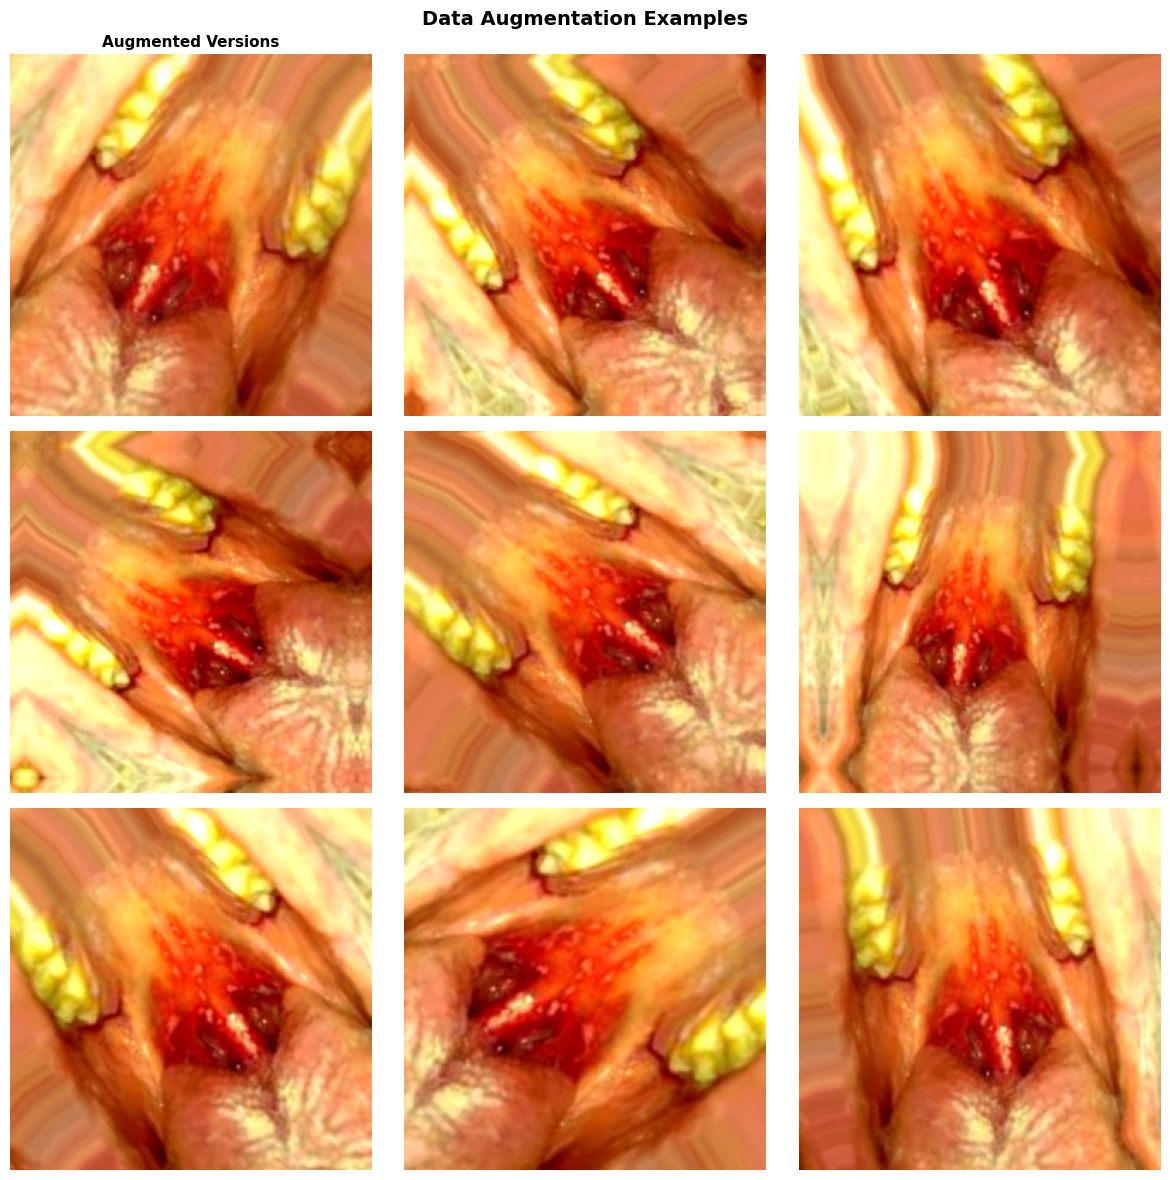

✅ Saved: augmentation_examples.png



In [87]:
print("Generating augmentation examples...")

for images, labels in train_ds.take(1):
    original_image = images[0]

plt.figure(figsize=(12, 12))
for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training=True)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    if i == 0:
        plt.title("Augmented Versions", fontsize=11, fontweight='bold')
    plt.axis("off")

plt.suptitle("Data Augmentation Examples", fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/teeth_classification/outputs/figures/augmentation_examples.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: augmentation_examples.png\n")


Preprocessing model

In [53]:
preprocess = tf.keras.Sequential([
    data_augmentation,
    normalization_layer
])

# Build CNN Model

In [92]:
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Preprocessing
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    # Block 1
    x = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x) # Mild dropout
    # Block 3
    x = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    # Block 4
    x = layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    # Block 5 (Deeper for better features)
    x = layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x) # Replace Flatten with GAP to reduce parameters
    # Dense Head
    x = layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x) # Stronger dropout before robust classification

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name="Custom_CNN_Improved")
    return model
model = build_model((256, 256, 3), NUM_CLASSES)
model.summary()

Model: "Custom_CNN_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,16

 Total params: 1,639,623 (6.25 MB)

 Trainable params: 1,637,383 (6.25 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [94]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training the Model

Setup Callbacks

In [95]:
callbacks = [
    ModelCheckpoint(
        filepath='/content/drive/MyDrive/teeth_classification/outputs/models/baseline_cnn_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [96]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2656 - loss: 4.3109
Epoch 1: val_accuracy improved from -inf to 0.17315, saving model to /content/drive/MyDrive/teeth_classification/outputs/models/baseline_cnn_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 242ms/step - accuracy: 0.2657 - loss: 4.3091 - val_accuracy: 0.1732 - val_loss: 4.4661 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.3169 - loss: 3.6598
Epoch 2: val_accuracy did not improve from 0.17315
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.3171 - loss: 3.6583 - val_accuracy: 0.1459 - val_loss: 5.5511 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3511 - loss: 3.1387
Epoch 3: val_accuracy did not improve from 0.17315
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.3512 - loss: 3.1376 - val_accuracy: 0.1566 - val_loss: 4.1183 - learning_rate: 0.0010
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy

✅ Training curves saved.


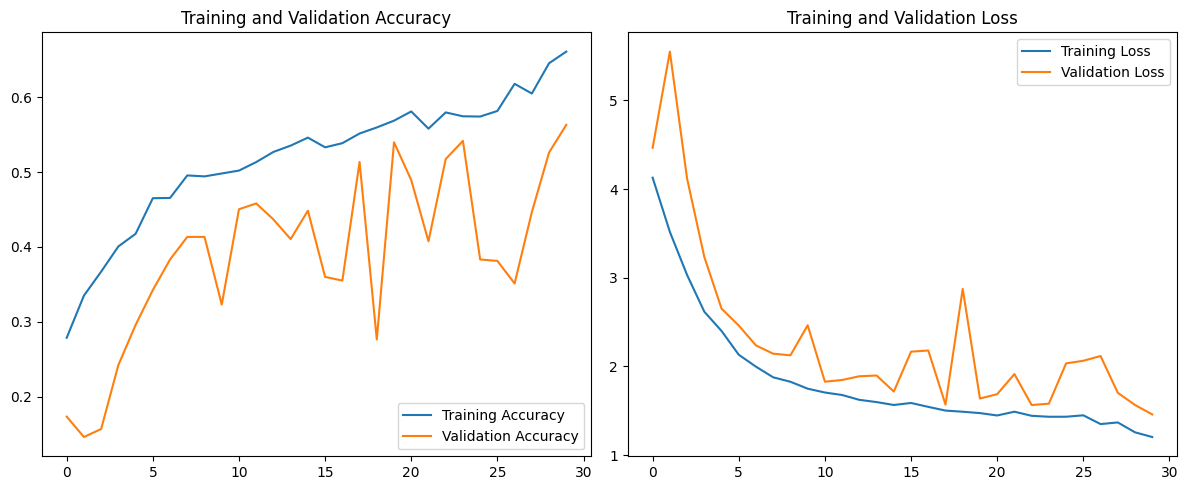

In [100]:
OUTPUT_DIR = '/content/drive/MyDrive/teeth_classification/outputs'

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'figures/training_curves_improved.png'))
    print("✅ Training curves saved.")
plot_history(history)


In [27]:
import os
import shutil

TEST_DIR = "/content/data/Teeth_Dataset/Testing"

# List everything in Testing
for item in os.listdir(TEST_DIR):
    path = os.path.join(TEST_DIR, item)

    # Delete files
    if os.path.isfile(path):
        os.remove(path)
        print(f"Deleted file: {path}")

    # Delete unrelated folders
    elif os.path.isdir(path):
        # Only delete if it's NOT one of the 7 class folders
        if item not in ['CaS','CoS','Gum','MC','OC','OLP','OT']:
            shutil.rmtree(path)
            print(f"Deleted folder: {path}")

# Verify remaining contents
print("Remaining folders in Testing:", os.listdir(TEST_DIR))


Remaining folders in Testing: ['OLP', 'Gum', 'CaS', 'OT', 'OC', 'CoS', 'MC']


In [28]:
# Check your dataset size
print("Dataset sizes:")
print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

# Estimate total images
train_size = len(train_ds) * BATCH_SIZE
val_size = len(val_ds) * BATCH_SIZE
test_size = len(test_ds) * BATCH_SIZE

print(f"\nEstimated images:")
print(f"Training: ~{train_size}")
print(f"Validation: ~{val_size}")
print(f"Testing: ~{test_size}")

Dataset sizes:
Training batches: 97
Validation batches: 33
Test batches: 48

Estimated images:
Training: ~3104
Validation: ~1056
Testing: ~1536


# Evaluation

In [101]:
print("\n📊 Evaluating on Test Set...")
# Load best model for evaluation
best_model = tf.keras.models.load_model(os.path.join(OUTPUT_DIR, 'models/best_custom_cnn.keras'))
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
# Classification Report
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)
with open(os.path.join(OUTPUT_DIR, 'results/classification_report_improved.txt'), 'w') as f:
    f.write(report)


📊 Evaluating on Test Set...


ValueError: File not found: filepath=/content/drive/MyDrive/teeth_classification/outputs/models/best_custom_cnn.keras. Please ensure the file is an accessible `.keras` zip file.

In [102]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

with open('/content/drive/MyDrive/teeth_classification/outputs/results/classification_report.txt','w') as f:
    f.write(report)

NameError: name 'y_true' is not defined

Confusion Matrix

In [103]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_DIR, 'figures/confusion_matrix_improved.png'))
print("✅ Confusion Matrix saved.")

NameError: name 'y_true' is not defined